In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
cd ./drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW3

[Errno 2] No such file or directory: './drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW3'
/content/drive/MyDrive/NTU_ML2017_Hung-yi-Lee_HW/HW3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import math

In [ ]:
def pd_to_np(df):

  if "label" in df.columns:
    train_y = np.array(df["label"])

  train_x = list(df["feature"])
  train_x = [ravel_photo.split(" ") for ravel_photo in train_x]
  train_x = np.array(train_x)

  train_x = train_x.astype(np.float32)

  ## scalize
  train_x = (train_x - train_x.mean(axis=0).reshape((1,-1))) / train_x.std(axis=0).reshape((1,-1))

  train_x = train_x.reshape((-1,1,48,48))

  if "label" in df.columns:
    return train_x, train_y
  else:
    return train_x

In [ ]:
class photo_dataset(Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y

  def __getitem__(self,idx): ## 不是 __getitems__
    return self.x[idx,:,:,:], self.y[idx]

  def __len__(self):
    return self.x.shape[0]

In [ ]:
train_df = pd.read_csv("./data/train.csv")
# test_df = pd.read_csv("./data/test.csv")

train_x, train_y = pd_to_np(train_df)
# test_x = pd_to_np(test_df)

val_rate = 0.2
val_index = int(math.floor(train_x.shape[0] * val_rate))

val_x = torch.from_numpy(train_x[:val_index,:,:,:])
val_y = torch.from_numpy(train_y[:val_index])
train_x = torch.from_numpy(train_x[val_index:,:,:,:])
train_y = torch.from_numpy(train_y[val_index:])

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
# print(test_x.shape)

train_photo_dataset = photo_dataset(train_x, train_y)
val_photo_dataset = photo_dataset(val_x, val_y)

train_photo_dataloader = DataLoader(train_photo_dataset, batch_size=32, shuffle=True)
val_photo_dataloader = DataLoader(val_photo_dataset, batch_size=32, shuffle=False)

torch.Size([22968, 1, 48, 48]) torch.Size([22968])
torch.Size([5741, 1, 48, 48]) torch.Size([5741])


In [ ]:
######### **kwarg

In [ ]:
###
class emotion_model(nn.Module):
  def __init__(self, feature_size, output_size, f1=16, f2=4, h1=400, h2=10, h3=1):
    super(emotion_model,self).__init__()
    self.conv1 = nn.Conv2d(1,f1,3)
    self.maxpool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(f1,f2,3)
    self.maxpool2 = nn.MaxPool2d(2)
    self.flatten1 = nn.Flatten()
    self.linear1 = nn.Linear(h1,output_size)
    self.flatten2 = nn.Flatten()
    self.softmax = nn.Softmax()
    self.net = nn.Sequential(
        self.conv1,
        self.maxpool1,
        self.conv2,
        self.maxpool2,
        self.flatten1,
        self.linear1,
        self.flatten2,
        self.softmax
    )

  def forward(self,x):
    return self.net(x)

  ## dropout

In [ ]:

model_name = "" #@param {type:"string"}

epoch = 5 #@param {type:"integer"}

learning_rate = 0.01 #@param {type:"number"}


optim_method = "rms" #@param ["sgd","adam","rms"]




In [ ]:
torch.manual_seed(0)

model = emotion_model(train_x.shape[1],7,f1=128,f2=32,h1=3200)
loss_function = nn.CrossEntropyLoss()

if optim_method == "sgd":
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
elif optim_method == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim_method == "rms":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.7)
else:
  raise Exception("no such optimizer")

In [ ]:
torch.manual_seed(0)
total_train_loss = []
total_train_acc = []
total_val_loss = []
total_val_acc = []

for time in tqdm(range(epoch)):
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []


  for batch_x, batch_y in train_photo_dataloader:
    model.train()
    optimizer.zero_grad()
    batch_x.to(torch.float32).to(torch.device("cpu"))
    batch_y.to(torch.float32).to(torch.device("cpu"))

    hypo_y = model(batch_x).squeeze()
    loss = loss_function(hypo_y,batch_y)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      hypo_y = model(batch_x).squeeze()
      loss = loss_function(hypo_y,batch_y)
      # print(loss.shape)
      # print(batch_y.shape)
      train_loss_list.append(loss.item())

      hypo_y_label = torch.argmax(hypo_y,dim=1)
      train_acc = torch.count_nonzero(hypo_y_label == batch_y) / batch_y.shape[0]

      train_acc_list.append(train_acc.item())

  model.eval()
  for val_batch_x, val_batch_y in val_photo_dataloader:
    val_batch_x.to(torch.float32).to(torch.device("cpu"))
    val_batch_y.to(torch.float32).to(torch.device("cpu"))
    with torch.no_grad():
      hypo_y = model(val_batch_x).squeeze()
      loss = loss_function(hypo_y,val_batch_y)

      val_loss_list.append(loss.item())
      hypo_y_label = torch.argmax(hypo_y,dim=1)
      val_acc = torch.count_nonzero(hypo_y_label == val_batch_y) / val_batch_y.shape[0]

      val_acc_list.append(val_acc.item())

  total_train_loss.append(np.mean(train_loss_list))
  total_train_acc.append(np.mean(train_acc_list))
  total_val_loss.append(np.mean(val_loss_list))
  total_val_acc.append(np.mean(val_acc_list))

100%|██████████| 5/5 [29:59<00:00, 359.87s/it]


ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

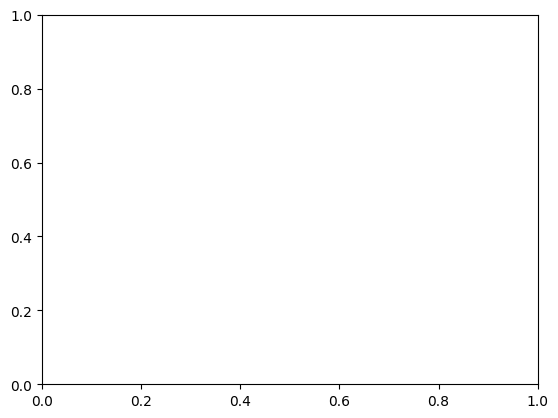

In [ ]:
plt.plot(range(epoch),total_train_loss,"b",label="train")
plt.plot(range(epoch),total_val_loss,"r",label="test")
plt.legend()
plt.show()

plt.plot(range(epoch),total_train_acc,"b",label="train")
plt.plot(range(epoch),total_val_acc,"r",label="test")
plt.legend()
plt.show()

In [ ]:
# # batch_x = train_x[0,:,:,:][None,:,:,:]
# batch_x = train_x[:2,:,:,:]
# batch_y = train_y[:2]

# output1 = model.conv1(batch_x)
# output2 = model.maxpool1(output1)
# output3 = model.conv2(output2)
# output4 = model.maxpool2(output3)
# output5 = model.flatten1(output4)
# output6 = model.linear1(output5)
# output7 = model.flatten2(output6)
# hypo_y = model.softmax(output7)

# print(output7.shape)
# print(hypo_y.shape)

# hypo_y = model(batch_x).squeeze()
# print(hypo_y.shape)
# print(hypo_y * 100)
# print(torch.round(hypo_y * 100)/100)
# print(batch_y)
# loss = loss_function(hypo_y,batch_y)
# print(loss.shape)
# print(loss.item())
# print(batch_y.shape)

# print(batch_y.item())

# ## 直接帶入 label?
